# Example 2: Comparison of dimensionless learning with popular machine learning algorithms

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/xiaoyuxie-vico/PyDimension-Book/blob/main/examples/2_1_cross_materials.ipynb)

## Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import matrix_rank
from numpy.linalg import inv
import pandas as pd
import pysindy as ps
import random
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from scipy.optimize import minimize
import xgboost
import warnings

warnings.filterwarnings("ignore")
%matplotlib inline
plt.rcParams["font.family"] = 'Arial'
np.set_printoptions(suppress=True)

In [2]:
class DimensionlessLearning(object):
    '''
    Indentify the explicit form one coefficient using dimensionless learning
    '''
    
    def __init__(self, df, input_list, output_list, dimension_info, basis_list):
        super(DimensionlessLearning, self).__init__()
        self.df = df
        self.input_list = input_list
        self.output_list = output_list
        self.X, self.y = self.prepare_dataset()
        self.dimension_info, self.basis_list = dimension_info, basis_list
        self.basis1_in, self.basis2_in, self.basis3_in = self.prepare_dimension()

    def prepare_dataset(self):
        '''
        prepare the input and output data
        '''
        X = self.df[self.input_list].to_numpy()
        y = self.df[self.output_list].to_numpy().reshape(-1, 1)
        return X, y
        
    def prepare_dimension(self):
        '''
        parse dimension for input and output
        '''
        basis1_in, basis2_in, basis3_in = self.basis_list
        return basis1_in, basis2_in, basis3_in

    def fetch_coef_pi(self, coef):
        '''
        parse the combined weights for the input
        '''
        coef_pi = coef[0] * self.basis1_in + coef[1] * self.basis2_in + coef[2] * self.basis3_in
        return coef_pi
        
    def check_dimension(self, coef):
        '''
        check whether the basis vectors can formulated as the D_out
        '''
        coef_pi = self.fetch_coef_pi(coef)
        # print('[check] coef_pi: \n', coef_pi)
        target_D_out = np.dot(self.dimension_info[0], coef_pi)
        # print('[check] target_D_out: \n', target_D_out)
        assert np.array_equal(target_D_out, self.dimension_info[1]), 'Wrong target_D_out!'

    def predict(self, X, coef, coef_w):
        '''
        Predict
        '''
        pi_in = np.prod(np.power(X, coef.reshape(-1,)), axis=1).reshape(1, -1)
        feats_train = self.parse_feats(pi_in)
        pred = np.sum(np.multiply(feats_train, coef_w), axis=1)
        return pred

    def parse_feats(self, arr, degree=5):
        # prepare different degrees' features
        feats_list = []
        for degree_idx in range(degree+1):
            feats_list.append(arr**degree_idx)
        feats = np.vstack(feats_list).T
        return feats

    def fit_pattern_search(self, max_ps=10, seed=0):
        idx = 0
        r2, basis_coef_final, reg_coef_final, coef_w_final = 0, None, None, None
        while idx <= max_ps:
            r2_temp, basis_coef_temp, reg_coef_temp, coef_w_temp = self.fit_pattern_search_base(seed=idx+seed*max_ps)
            idx += 1
            if r2_temp > r2:
                r2, basis_coef_final, reg_coef_final, coef_w_final = r2_temp, basis_coef_temp, reg_coef_temp, coef_w_temp
        return r2, basis_coef_final, reg_coef_final, coef_w_final

    def fit_pattern_search_base(self, seed=0):
        '''
        pattern search
        '''
        def get_coordinates(a, b, c, delta):
            '''
            Build a list to store all possible coordiantes
            '''
            coord_all = []
            for b_ in [b-delta, b, b+delta]:
                for c_ in [c-delta, c, c+delta]:
                    if [b_, c_] != [b, c]:
                        coord_all.append([a, b_, c_])
            return coord_all

        def opt(coef):
            '''
            fit a linear regression
            '''
            coef_pi = self.fetch_coef_pi(coef)
            pi_in = np.prod(np.power(self.X, coef_pi.reshape(-1,)), axis=1).reshape(1, -1)
            feats_train = self.parse_feats(pi_in)
            reg =LinearRegression(fit_intercept=False)
            reg.fit(feats_train, self.y)
            y_pred = reg.predict(feats_train)
            r2 = r2_score(self.y, y_pred)
            return r2, coef_pi, reg.coef_

        np.random.seed(seed)
        res, break_points = [], []
        a = 0.5
        # b, c = 1, 1
        b = np.random.choice(np.linspace(-2, 2, 9), 1)[0]  # [-2, 2] delta=0.5
        c = np.random.choice(np.linspace(-2, 2, 9), 1)[0]  # [-2, 2] delta=0.5
        coef = np.array([a, b, c]).reshape(-1, 1)

        iter_num, max_iter, delta = 0, 10, 0.5
        while iter_num < max_iter:
            candidate_coord = get_coordinates(a, b, c, delta)
            r2_center, reg_coef_center, coef_w_center = opt(coef)
            # print('r2_center', round(r2_center, 2), 'reg_coef_center', [round(each, 2) for each in list(reg_coef_center.reshape(-1,))])
            # print('coef_w_center', coef_w_center)

            if r2_center < 0.2:
                break_points.append([a, b, c])
                break

            r2_bounds_val = []
            for [a_, b_, c_] in candidate_coord:
                coef_temp = np.array([a_, b_, c_]).reshape(-1, 1)
                r2_bound, reg_coef_bound, coef_w_bound = opt(coef_temp)
                r2_bounds_val.append(r2_bound)

            # sort r2 from high to low
            highest_index = np.argsort(r2_bounds_val)[::-1][0]
            iter_num += 1

            # udpate the center coordiantes when the R2 in the neighborhood is higher
            if r2_center < r2_bounds_val[highest_index]:
                [a, b, c] = candidate_coord[highest_index]
                coef = np.array([a, b, c]).reshape(-1, 1)
                coef_pi = self.fetch_coef_pi(coef)
                res_info = {'a': a, 'b': b, 'c': c, 'r2_center': round(r2_bounds_val[highest_index], 4)}
                # print('update', res_info)
                res.append(res_info)
            else:
                break
        
        basis_coef = [a, b, c]
        coef_pi = self.fetch_coef_pi(coef)
        r2, reg_coef, coef_w = opt(coef)
        self.gamma, self.beta = reg_coef, int(round(coef_w[0][0], 0))

        return r2, basis_coef, reg_coef, coef_w

In [3]:
# load dataset
df = pd.read_csv('../dataset/dataset_keyhole.csv')
input_list = ['etaP', 'Vs', 'r0', 'alpha', 'rho', 'cp', 'Tl-T0']
output_list = ['e*']

# split dataset
df_train = df[df['source']!='Mat3']
df_test = df[df['source']=='Mat3']

X_train_val = df_train[input_list].to_numpy()
y_train_val = df_train[output_list].to_numpy().reshape(-1,)

X_test = df_test[input_list].to_numpy()
y_test = df_test[output_list].to_numpy().reshape(-1,)

# shuffle
X_train_val, y_train_val = shuffle(X_train_val, y_train_val, random_state=0)

data_train_val = np.concatenate([X_train_val, y_train_val.reshape(-1, 1)], axis=1)
data_test = np.concatenate([X_train_val, y_train_val.reshape(-1, 1)], axis=1)
print(f'[Dataset] X_train: {data_train_val.shape}, X_test: {data_test.shape}')

[Dataset] X_train: (83, 8), X_test: (83, 8)


In [4]:
# Dimensionless learning
D_in = np.array(
    [
        [2., 1., 1., 2., -3., 2., 0.],
        [-3., -1., 0., -1., 0., -2., 0.],
        [1., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., -1., 1.],
    ],
)
D_out = np.array(
    [
        [1.],
        [0.],
        [0.],
        [0.],
    ]
)
dimension_info = [D_in, D_out]

# best weights for Ke: 0.5, 1, 1
scaling_mat = np.array(
    [
        [0., 0., 1],
        [1, 2., -3],
        [1, 0., -2.],
        [-1, 0., 0.],
        [0., 0., -1],
        [0., -1, 0.],
        [0., -1, 0.]],
)
basis1_in = scaling_mat[:, 0]
basis2_in = scaling_mat[:, 1]
basis3_in = scaling_mat[:, 2]
basis_list = [basis1_in, basis2_in, basis3_in]


# cross-validation
model_name_list = ['dimensionless_learning'] * 5
r2_train_list, r2_val_list, r2_tes_list = [], [], []
# ss = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
ss = KFold(n_splits=5, random_state=0, shuffle=True)

for seed, (train_index, val_index) in enumerate(ss.split(data_train_val)):

    X_train, y_train = data_train_val[train_index, :-1], data_train_val[train_index, -1].reshape(-1, 1)
    X_val, y_val = data_train_val[val_index, :-1], data_train_val[val_index, -1].reshape(-1, 1)
    df_train_temp = pd.DataFrame(data_train_val, columns=input_list+output_list)

    print('*'*40, seed)
    dimensionless_learning = DimensionlessLearning(df_train_temp, input_list, output_list, dimension_info, basis_list)
    r2, basis_coef, power_coef, coef_w = dimensionless_learning.fit_pattern_search(max_ps=10, seed=seed)
    # print('final r2', r2, basis_coef, power_coef.flatten(), coef_w)
    print(f'final train-r2: {r2:.4f}, basis_coef: {basis_coef}')
    y_train_pred = dimensionless_learning.predict(X_train, power_coef, coef_w)
    y_val_pred = dimensionless_learning.predict(X_val, power_coef, coef_w)
    y_test_pred = dimensionless_learning.predict(X_test, power_coef, coef_w)
    r2_train, r2_val, r2_test = r2_score(y_train, y_train_pred), r2_score(y_val, y_val_pred), r2_score(y_test, y_test_pred)
    print(f'\t r2_train: {r2_train:.4f}, r2_val: {r2_val:.4f}, r2_test: {r2_test:.4f}')
    r2_train_list.append(r2_train), r2_val_list.append(r2_val), r2_tes_list.append(r2_test)

df_dimension = pd.DataFrame(np.array([model_name_list, r2_train_list, r2_val_list, r2_tes_list]).T, columns=['model_name', 'Train', 'Val', 'Test'])
print(df_dimension)

**************************************** 0
final train-r2: 0.9818, basis_coef: [0.5, 1.0, 1.0]
	 r2_train: 0.9819, r2_val: 0.9797, r2_test: 0.9656
**************************************** 1
final train-r2: 0.9818, basis_coef: [0.5, 1.0, 1.0]
	 r2_train: 0.9792, r2_val: 0.9887, r2_test: 0.9656
**************************************** 2


final train-r2: 0.9818, basis_coef: [0.5, 1.0, 1.0]
	 r2_train: 0.9829, r2_val: 0.9773, r2_test: 0.9656
**************************************** 3
final train-r2: 0.9818, basis_coef: [0.5, 1.0, 1.0]
	 r2_train: 0.9845, r2_val: 0.9574, r2_test: 0.9656
**************************************** 4
final train-r2: 0.9818, basis_coef: [0.5, 1.0, 1.0]
	 r2_train: 0.9796, r2_val: 0.9876, r2_test: 0.9656
               model_name               Train                 Val  \
0  dimensionless_learning   0.981855725365724  0.9796559523082451   
1  dimensionless_learning  0.9791693204546573  0.9887215162324866   
2  dimensionless_learning  0.9828631202803692  0.9772939065990666   
3  dimensionless_learning  0.9844770567152685  0.9573732587431291   
4  dimensionless_learning  0.9796137914185901  0.9876384500403704   

                 Test  
0  0.9656313205488951  
1  0.9656313205488951  
2  0.9656313205488951  
3  0.9656313205488951  
4  0.9656313205488951  


Text(0, 0.5, 'e*')

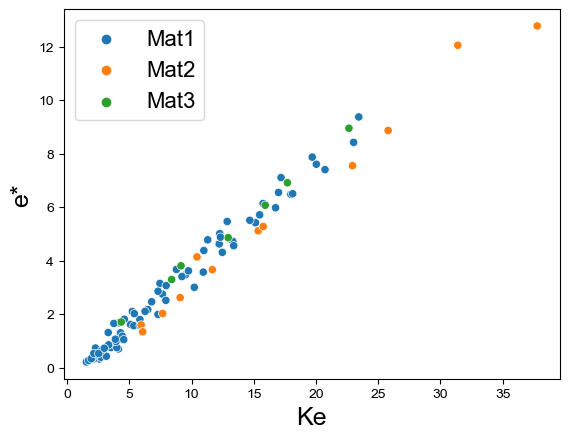

In [5]:
fig = plt.figure()
ax = sns.scatterplot(data=df, x='Ke', y='e*', hue='source')
ax.legend(fontsize=16); ax.set_xlabel('Ke', fontsize=18); ax.set_ylabel('e*', fontsize=18)

In [6]:
# load dataset
df = pd.read_csv('../dataset/dataset_keyhole.csv')
input_list = ['etaP', 'Vs', 'r0', 'alpha', 'rho', 'cp', 'Tl-T0']
output_list = ['e']

# split dataset
df_train = df[df['source']!='Mat3']
df_test = df[df['source']=='Mat3']

X_train_val = df_train[input_list].to_numpy()
y_train_val = df_train[output_list].to_numpy().reshape(-1,)

X_test = df_test[input_list].to_numpy()
y_test = df_test[output_list].to_numpy().reshape(-1,)

# shuffle
X_train_val, y_train_val = shuffle(X_train_val, y_train_val, random_state=0)

data_train_val = np.concatenate([X_train_val, y_train_val.reshape(-1, 1)], axis=1)
data_test = np.concatenate([X_train_val, y_train_val.reshape(-1, 1)], axis=1)
print(f'[Dataset] X_train: {data_train_val.shape}, X_test: {data_test.shape}')

[Dataset] X_train: (83, 8), X_test: (83, 8)


In [7]:
# normalization
scaler = StandardScaler()
X_train_val_transformed = scaler.fit_transform(X_train_val)
X_test_transformed = scaler.transform(X_test)

# rescale y for MLP
y_train_val = y_train_val * 1e5
y_test = y_test * 1e5

In [8]:
def train_eval(model_name, para_grids):
    '''
    Cross-validation and evaluate on the test set
    '''
    # GridSearchCV to search the best parameters for the model
    estimator = eval(f'{model_name}()')
    grid = GridSearchCV(estimator, para_grids, scoring='r2', cv=5)
    grid.fit(X_train_val_transformed, y_train_val)
    # best_model = grid.best_estimator_
    print(f'model_name: {model_name}')
    print(f'best_params:{grid.best_params_}')
    model_name_list = [model_name] * 5

    # cross-validation
    # ss = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    ss = KFold(n_splits=5, random_state=0, shuffle=True)
    r2_train_list, r2_val_list, r2_tes_list = [], [], []
    for train_index, val_index in ss.split(X_train_val_transformed):
        model = eval(f'{model_name}(**grid.best_params_)')
        X_train, y_train = X_train_val_transformed[train_index, :], y_train_val[train_index]
        X_val, y_val = X_train_val_transformed[val_index, :], y_train_val[val_index]
        model.fit(X_train, y_train)
        r2_train, r2_val, r2_test = model.score(X_train, y_train), model.score(X_val, y_val), model.score(X_test_transformed, y_test)
        # print(f'r2_train: {r2_train:.4f}, r2_val: {r2_val:.4f}, r2_test: {r2_test:.4f}')
        r2_train_list.append(r2_train), r2_val_list.append(r2_val), r2_tes_list.append(r2_test)

    df = pd.DataFrame(np.array([model_name_list, r2_train_list, r2_val_list, r2_tes_list]).T, columns=['model_name', 'Train', 'Val', 'Test'])
    return df

In [9]:
# key: model_name, value: para_grids
configs = {
    'MLPRegressor': {
        'hidden_layer_sizes': [(100, 100, 100), (50, 100, 50)], 
        'alpha': [0.00005, 0.0005],
        'max_iter': [200, 500, 800],
        'learning_rate': ['constant','adaptive'],
        'random_state': [0],
    },
    'LinearRegression': {},
    'xgboost.XGBRegressor': {
        'n_estimators': [20, 50, 80], 
        'max_depth': [5, 10, 20],
        'seed': [0],
    },
    'KNeighborsRegressor': {
        'n_neighbors': [2, 3, 4, 5],
        'weights': ['uniform', 'distance'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    },
    'RandomForestRegressor': {
        'n_estimators' : [10, 50, 100, 200], 
        'max_features' : ['auto', 'log2', 'sqrt'], 
        'bootstrap' : [True, False], 
        'random_state': [0]
    },
}

In [10]:
# combine different models' results
res = []
for model_name, para_grids in configs.items():
    res_each = train_eval(model_name, para_grids)
    res.append(res_each)
res.append(df_dimension)
res_all = pd.concat(res)
res_all = res_all.astype({'Train': 'float64', 'Val': 'float64', 'Test': 'float64'})
res_all.head()

In [11]:
model_name_map = {
    'dimensionless_learning': 'Proposed \n method',
    'RandomForestRegressor': 'RF',
    'MLPRegressor': 'FFNN',
    'LinearRegression': 'LR',
    'KNeighborsRegressor': 'KNN',
    'xgboost.XGBRegressor': 'XGBoost',
}

res_final = []
for i in range(res_all.shape[0]):
    each_row = res_all.iloc[i]
    model_name = model_name_map[each_row['model_name']]
    res_final.append([model_name, float(each_row['Train']), 'Training set'])
    res_final.append([model_name, float(each_row['Val']), 'Validation set'])
    res_final.append([model_name, float(each_row['Test']), 'Test set'])

df_final = pd.DataFrame(res_final, columns=['Model_name', 'R2', 'Data source'])
df_final.head()

,Model_name,R2,Data source
0,FFNN,0.996447,Training set
1,FFNN,0.980201,Validation set
2,FFNN,-2.301915,Test set
3,FFNN,0.995823,Training set
4,FFNN,0.986937,Validation set


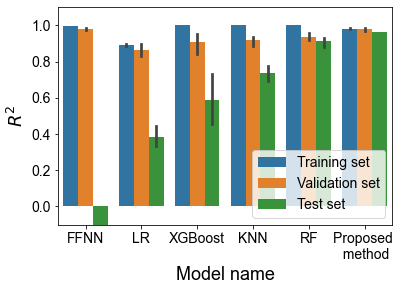

In [12]:
fig = plt.figure()
sns.barplot(data=df_final, x='Model_name', y='R2', hue='Data source')
plt.ylim([-0.1, 1.1])
plt.legend(fontsize=14, loc=4)
plt.xlabel('Model name', fontsize=18)
plt.ylabel(r'$R^2$', fontsize=18)
plt.tick_params(labelsize=14)
plt.show()